## Import

In [1]:
import numpy as np
import scipy.integrate as integ
import scipy.interpolate as i2
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from astropy import units as u
from astropy import constants as c
# import cmath as cm
from shooting import *
import shootingres as shr
import shooting as sho

import scipy.optimize as o
try:
    import cPickle as pickle
except ImportError:
    import pickle

import pandas as pd 
# import ray
from scipy.integrate import cumtrapz
import seaborn as sns
sns.set_theme()
sns.set_style("white")
sns.set_style("ticks")
sns.set_style("ticks",{'axes.grid' : True})
import scienceplots
plt.style.use('science')

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
f = 16

In [2]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1.5
# plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.size': 12})
# plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'axes.labelsize': 12})

plt.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})


In [3]:
## SET CONSTANTS
rho = (1.0*10**19) * (2.0*1.6725*10**(-27))
mu_0 = 1.2566*10**(-6)

# Define Normalizations
r1 = 0.1

## Define OMEGA0:
bb = 10000
v0 = bb/np.sqrt(r1)
Omega0 = v0/r1

## MCI Hain

In [4]:
data = pd.read_csv('Re750_4_0.1_0_to_1.txt', header = None, delim_whitespace=True)
r_f = data[0]
W = data[1]
W_f = i2.CubicSpline(r_f, W)
Wp_f = W_f.derivative()
Wpp_f = Wp_f.derivative()

# plt.figure()
# plt.plot(r_f, W_f(r_f))
# plt.plot(r_f, Wp_f(r_f))
# plt.plot(r_f,Wpp_f(r_f))
# plt.show()
# plt.close()
def shoot_hain_v3(w, eta, Pm, qr, qrp, qi, qip,  k=np.pi/2, m=1, B0=0, Bz = 0, keplerian=True, cc=1, r2=5, max=500, q=1/2):
    ## DIFF IS INCLUDES IMAG
    y0 = [0.,1.+1.j]
    y = i.solve_ivp(shoot_setup_hain_v2, [1,r2**2], y0, args=(w,eta, Pm, qr, qrp, qi, qip, m,k,B0,Bz, keplerian,cc, q), max_step=24./(max/r2))
    r = np.sqrt(y.t)
    u = y.y[0]
    return ((u/r)[-1])

### REDONE DERIVATION
def shoot_setup_hain_v2(x, y, w, elecd, Pm, k2rs, k2rps, k2is, k2ips, m, kz=np.pi/4, B0=60, Bz=12.967, keplerian=True, cc=1, q=1/2):
    mu_0 = 1.2566*10**(-6)
     ### PM = 1
    r = np.sqrt(x)
    k2 = k2rs(r) + 1j*k2is(r)
    k2p = k2rps(r) + 1j*k2ips(r)
    vp1 = 1
    if keplerian == True:
        W = vp1 / r**(3/2)
        Wp = -3/2 * vp1 / r**(5/2)
        Wpp = 5/2 * 3/2 * vp1 / r ** (7/2)
    elif keplerian == 'khalzov':
        W = vp1/x
        Wp = -vp1/x**2
    elif keplerian == 'rigid':
        W = vp1
        Wp = 0
    elif keplerian == 'Sh2':
        W = vp1/r**2
        Wp = -2*vp1/r**3
        Wpp = 6*vp1/r**4
    elif keplerian == False:
        vp = vp1/(x**(q/2))
        W = vp/r
        Wp = (-1*(q+1)/2)*(W/x)
    elif keplerian == 'saturated':
        A0 = 1.4923889E-02
        A1 = -1.0114824E-01
        A2 = 8.5753488E-02
        A3 = -2.8021088E-02
        A4 = -4.7882189E-01
        A5 = 1.0877462E-01
        A6 = 6.7857446E+00
        A7 = -5.0846913E+00
        A8 = -4.3114342E+01
        A9 = 5.2943846E+01
        A10 = 1.2219068E+02
        A11 = -1.9185099E+02
        A12 = -1.7535573E+02
        A13 = 3.4808679E+02
        A14 = 1.1975807E+02
        A15 = -3.4500839E+02
        A16 =  -1.4844420E+01
        A17 = 1.7930272E+02
        A18 = -2.5033736E+01
        ###  0.08875 + 0.91125/r^2 
        W = 0.08875 + 0.91125/r**2 + A0 + A1*(r-2) + A2*(r-2)**2+A3*(r-2)**3 + A4*(r-2)**4 + A5*(r-2)**5 + A6*(r-2)**6 + A7*(r-2)**7 + A8*(r-2)**8 + A9*(r-2)**9 + A10*(r-2)**10 + A11*(r-2)**11 + A12*(r-2)**12 + A13*(r-2)**13 + A14*(r-2)**14 + A15*(r-2)**15 + A16*(r-2)**16 + A17*(r-2)**17 + A18*(r-2)**18 - ( A1 + A3 + A5 + A7 + A9 + A11 + A13 + A15 + A17 )*(r-2)**19 - ( A0 + A2 + A4 + A6 + A8 + A10 + A12 + A14 + A16 + A18 )*(r-2)**20
        Wp = - 2 * 0.91125/r**3  + A1 + 2*A2*(r-2) + 3*A3*(r-2)**2 + 4*A4*(r-2)**3 + 5*A5*(r-2)**4 + 6*A6*(r-2)**5 + 7*A7*(r-2)**6 + 8*A8*(r-2)**7 + 9*A9*(r-2)**8 + 10*A10*(r-2)**9 + 11*A11*(r-2)**10 + 12*A12*(r-2)**11 + 13*A13*(r-2)**12 + 14*A14*(r-2)**13 + 15*A15*(r-2)**14 + 16*A16*(r-2)**15 + 17*A17*(r-2)**16 + 18*A18*(r-2)**17 - 19*( A1 + A3 + A5 + A7 + A9 + A11 + A13 + A15 + A17 )*(r-2)**18 - 20*( A0 + A2 + A4 + A6 + A8 + A10 + A12 + A14 + A16 + A18 )*(r-2)**19
        Wpp = 3 * 2 * 0.91125/r**4  + 2*A2 + 3 * 2 * A3*(r-2) + 4 * 3 * A4*(r-2)**2 + 5 * 4 * A5*(r-2)**3 + 6 * 5 * A6*(r-2)**4 + 7 * 6 * A7*(r-2)**5 + 8 * 7 * A8*(r-2)**6 + 9 * 8 * A9*(r-2)**7 + 10 * 9  * A10*(r-2)**8 + 11 * 10 * A11*(r-2)**9 + 12 * 11 * A12*(r-2)**10 + 13 * 12 * A13*(r-2)**11 + 14 * 13 * A14*(r-2)**12 + 15 * 14 * A15*(r-2)**13 + 16 * 15 * A16*(r-2)**14 + 17 * 16 * A17*(r-2)**15 + 18 * 17 * A18*(r-2)**16 - 19 * 18 * ( A1 + A3 + A5 + A7 + A9 + A11 + A13 + A15 + A17 )*(r-2)**17 - 20 * 19 * ( A0 + A2 + A4 + A6 + A8 + A10 + A12 + A14 + A16 + A18 )*(r-2)**18 
        
    elif keplerian == 'saturated2':
        W = W_f(r)
        Wp = Wp_f(r)
        Wpp = Wpp_f(r)
    elif keplerian == 'tanh':
        a = c = b = d = 1
        d = 0.85
        W = d*np.tanh(-c*r+a)+b
        Wp = -c * d * (1/np.cosh(-c * r + a))**2
        Wpp = -2 * c**2 * d * np.tanh(-c * r + a)*(1/np.cosh(-c * r + a))**2
    elif keplerian == 'tanhv3':
        a = c = b = d = 1
        d = 0.84
        W = d*np.tanh(-c*r+a)+b
        Wp = -c * d * (1/np.cosh(-c * r + a))**2
        Wpp = -2 * c**2 * d * np.tanh(-c * r + a)*(1/np.cosh(-c * r + a))**2
    elif keplerian == 'tanhv4':
        a = c = b = d = 1
        a = 0.6
        c = a
        d = 0.9
        W= d*np.tanh(-c*r+a)+b
        Wp = -c * d * (1/np.cosh(-c * r + a))**2
        Wpp = -2 * c**2 * d * np.tanh(-c * r + a)*(1/np.cosh(-c * r + a))**2
    elif keplerian == 'mKep':
        r10 = 1.5
        R0 = 1

        if(r < r10):
            W = 1
            Wp = 0
            Wpp = 0
        else:
            W = 1/(1+((r-r10)/R0)**(3/2))
            Wp = -3/(2*R0)*((r-r10)/R0)**(1/2)/(1+((r-r10)/R0)**(3/2))**2
            u = 1+((r-r10)/R0)**(3/2)
            up = 3/(2*R0)*((r-r10)/R0)**(1/2)
            Wpp = -( (3/(4*R0**2)*(1/R0*(r-r10))**(-1/2))*u**2 - (3/(2*R0) * (1/R0*(r-r10))**(1/2))*2*u*up)/(u**4)
    elif keplerian == 'mKep2':
        r10 = 1.5
        R0 = 1.5

        if(r < r10):
            W = 1
            Wp = 0
            Wpp = 0
        else:
            W = 1/(1+((r-r10)/R0)**(3/2))
            Wp = -3/(2*R0)*((r-r10)/R0)**(1/2)/(1+((r-r10)/R0)**(3/2))**2
            u = 1+((r-r10)/R0)**(3/2)
            up = 3/(2*R0)*((r-r10)/R0)**(1/2)
            Wpp = -( (3/(4*R0**2)*(1/R0*(r-r10))**(-1/2))*u**2 - (3/(2*R0) * (1/R0*(r-r10))**(1/2))*2*u*up)/(u**4)
        
    # Define Normalizations
    r1 = 0.1

    ## Define OMEGA0:
    bb = 10000
    v0 = bb/np.sqrt(r1)
    Omega0 = v0/r1

    vAp1 = B0/(r1*Omega0*np.sqrt(rho*mu_0)*10000)
    
    vAp = vAp1/np.sqrt(x)
    vAz = Bz / (r1*Omega0*np.sqrt(rho*mu_0)*10000)
    
    ### MODIFY w
    wA = (m/np.sqrt(x))*vAp + kz*vAz
    wb = w-m*W
    wc = 2*vAp/np.sqrt(x)*cc
    
    wAp = -m*vAp1/x**2*2*r
    wcp = -2*vAp1/x**2*cc*2*r


    # elecd = elecd / (r1**2*Omega0)*2
    elecd = elecd / (r1**2*Omega0)
    nu = elecd*Pm

    ### Note this is k2p with respect to r.
    wbp = -m*Wp
    wbpp = -m*Wpp
    lnu = -1j*wb + nu*k2
    lnup = -1j*wbp + nu*k2p
    leta = -1j*wb + elecd*k2
    letap = -1j*wbp + elecd*k2p
    
    L = lnu + wA**2/(leta)
    Lp = lnup + 2*wA*wAp/leta - wA**2*letap/(leta**2)
    h2 = kz**2 + m**2/r**2
    h = np.sqrt(h2)
    hp = -1/h*(m**2/r**3)
    E = L**2 + L*r/leta * wc * (1j*wA*Wp/leta - 1/2*wcp) + 2*(W - 1j*1/2*wc*wA/leta)*(2*W + (1+wA**2/leta**2)*r*Wp - 1j*wA*wc/leta)
    f = 2*r**2*(leta*lnu + wA**2)/((kz**2*r**2+m**2))
    fp = 1/(kz**2*r**2+m**2) * (4*r*(leta*lnu + wA**2) +2*r**2*(letap*lnu+leta*lnup + 2*wA*wAp)) - 1/(kz**2*r**2+m**2)**2 * (4*kz**2*r**3*(lnu*leta + wA**2))
    s = (1j*m*(lnu - leta)/(h**2*r)*Wp)
    g_dr_num_undiff = ((leta - lnu) * r * Wp + 2*(W*leta - 1/2*1j*wc*wA)) ## modified
    g_dr_num_diff = (letap - lnup) * r * Wp + (leta - lnu)*(Wp + r*Wpp) + 2*(Wp*leta + W*letap - 1/2*1j*wcp*wA - 1/2*1j*wc*wAp)
    g_dr_denom_undiff = h**2*r**2
    g_dr_denom_diff = 2*h*hp*r**2 + 2*h**2*r
    g_dr_term = 1j*m*(g_dr_num_diff/g_dr_denom_undiff - g_dr_num_undiff*g_dr_denom_diff/g_dr_denom_undiff**2)

    g = g_dr_term + E*leta/(L*r) - (W - 1j*1/2*wc*wA/leta)*(2*m**2/(L*h**2*r**3))*((leta - lnu)*r*Wp + 2*(W*leta - 1j * 1/2*wA*wc))

    u, du = y

    ### REWRITE ALL TERMS
    f = leta*L/(h**2*r)
    fp = (letap*L + leta*Lp)/(h**2*r) - leta*L*(2*h*hp*r+h**2)/(h**2*r)**2

    u_coeff = 1/(-4*r)*-g
    du_coeff = -1/(4*r)*(2*(f+r*fp)) - s/(2)
    d2u_coeff = -r*f
    dudx = [du, (1/d2u_coeff)*(-du_coeff*du - u_coeff*u)]

    return dudx


C:\Users\Alex\AppData\Local\Temp\ipykernel_9948\3992830679.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('Re750_4_0.1_0_to_1.txt', header = None, delim_whitespace=True)


## Resistive Method

In [5]:
r2 = 5
m = 1
kn = 1
kz = kn*np.pi/(4)

r = np.linspace(1, r2, 500)
q_mag = np.pi**2
q2r_sc = q_mag*1/r**2
q2rp_sc = q_mag*(-2/r**3)
q2rpp_sc = q_mag*(6/r**4)
q2i_sc = q_mag*np.zeros(len(r))
q2ip_sc = q_mag*np.zeros(len(r))
q2ipp_sc = q_mag*np.zeros(len(r))

ones_arr = np.ones(len(r)) 
k2 = (q2r_sc + 1j*q2i_sc) + m**2/r**2 + kz**2 * ones_arr
k2p = ((q2rp_sc + 1j*q2ip_sc) - 2 * m**2/r**3) ## just changed from d/dr
k2pp = ((q2rpp_sc + 1j*q2ipp_sc) + 6 * m**2/r**4) ## just changed from d/dr

k2r_curr = i2.CubicSpline(r, k2.real)
k2i_curr = i2.CubicSpline(r, k2.imag)
k2rp_curr = i2.CubicSpline(r, k2p.real)
k2ip_curr = i2.CubicSpline(r, k2p.imag)
k2rpp_curr = i2.CubicSpline(r, k2pp.real)
k2ipp_curr = i2.CubicSpline(r, k2pp.imag)

dt = 0.2
eta_arr = np.arange(0,200,dt)
kn_arr = np.arange(1, 10, dt)
dt = 0.01
kn_arr_down = np.flip(np.arange(0.4, 1+dt, dt))

# VA_N_arr_up = np.arange(0.2,.3,0.05)
# VA_N_arr_down = np.flip(np.arange(0,0.2+0.05, 0.05))

VA_N_arr_up = np.arange(0.1,.35,0.02)


## Initial Modes

In [6]:
##### SET PARAMETERS #####
color_arr = ['#3F90DA', '#FFA90E', '#BD1F01', '#94A4A2', '#832DB6', '#A96B59', '#E76300', '#B9AC70', '#92DADD']

reso = 5000

r1 = 0.1
q = 1/2
type = 'MCI'
elecd = 0
eta = elecd
Pm = 1
m = 1
kn = 1
kz = kn*np.pi/(4)
VA_N = 0.2
Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
B0 = 0

############## Kep
##### SET PARAMETERS #####
flow_type = 'Kep'

if(flow_type == 'Kep'):
    flow_select = True
elif(flow_type == 'Tanh'):
    flow_select = 'tanh'
elif(flow_type == 'Sat'):
    flow_select = 'saturated'
elif(flow_type == 'Sh2'):
    flow_select = 'Sh2'

## MCI 1k1
kn = 1
kz = kn*np.pi/(4)

VA_N = 0.1
Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
guess = (0.14822091614105812+0.030059885804441147j)

# VA_N = 0.2
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess = (0.20842493869616271+0.032206894149131714j)

# VA_N = 0.3
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess = (0.2774198383895069+0.028004839510766346j)

# ## MCI 2k1
# kn = 2
# kz = kn*np.pi/(4)

# VA_N = 0.1
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess = (0.23139601550724662+0.014125390255013989j)

# VA_N = 0.2
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess = (0.3248593920994146+0.027178993355378125j)

# VA_N = 0.3
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess = (0.480551578057316+0.0193104564505523j)



## MRI 1k1
VA_N = 0.1
Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
guess = (0.920888468850722+0.0005470798980508508j)

# VA_N = 0.2
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess = (0.8420543360966929+0.001271340872804506j)

# VA_N = 0.3
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess = (0.7633767422224405+0.0021175685804001526j)


# ## MRI 2k1
# kn = 2
# kz = kn*np.pi/(4)

# VA_N = 0.1
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess = (0.8391425990541925+0.02329953702103895j)

# VA_N = 0.2
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess = 0.6839591478878391+0.05167001239587j


# VA_N = 0.3
# Bz = VA_N* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
# guess =(0.5683728690870249+0.09949675824308628j)

result = o.root_scalar(shoot_hain_v3, method='secant', x0=guess*(1.00005+1e-6j), x1=guess*(0.99995-1e-6j), args=(eta, Pm, k2r_curr, k2rp_curr, k2i_curr, k2ip_curr, kz, m, B0, Bz, flow_select, 1, r2,reso), maxiter=5000)
guess0 = result.root
print(result)


      converged: True
           flag: converged
 function_calls: 6
     iterations: 5
           root: (0.9208884686878942+0.0005470802411997808j)
         method: secant


## All Modes

### 1k1 MRI

In [18]:
##### SET PARAMETERS #####
color_arr = ['#3F90DA', '#FFA90E', '#BD1F01', '#94A4A2', '#832DB6', '#A96B59', '#E76300', '#B9AC70', '#92DADD']

reso = 2000

r1 = 0.1
q = 1/2
type = 'MCI'
Pm = 1
m = 1
kn = 1
kz = kn*np.pi/(4)
B0 = 0

############## Kep
##### SET PARAMETERS #####
flow_type = 'Kep'

if(flow_type == 'Kep'):
    flow_select = True
elif(flow_type == 'Tanh'):
    flow_select = 'tanh'
elif(flow_type == 'Sat'):
    flow_select = 'saturated'
elif(flow_type == 'Sh2'):
    flow_select = 'Sh2'

complex_freqs_MRI_1k1_Kep_uu = np.zeros((len(VA_N_arr_up),len(kn_arr)), dtype = 'complex')
complex_freqs_MRI_1k1_Kep_uu[0][0] = (0.920888468850722+0.0005470798980508508j)


for k in range(0,len(VA_N_arr_up)):
    for j in range(0,len(kn_arr)):
        kz = kn_arr[j]*np.pi/4
        Bz = VA_N_arr_up[k]* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
        if(k == 0):
            if(j == 0):
                guess = complex_freqs_MRI_1k1_Kep_uu[k,j]
            else:
                guess = complex_freqs_MRI_1k1_Kep_uu[k,j-1]
        else:
            if(j == 0):
                guess = complex_freqs_MRI_1k1_Kep_uu[k-1,j]
            else:
                guess = complex_freqs_MRI_1k1_Kep_uu[k,j-1]

        result = o.root_scalar(shoot_hain_v3, method='secant', x0=guess*(1.00005+1e-6j), x1=guess*(0.99995-1e-6j), args=(eta, Pm, k2r_curr, k2rp_curr, k2i_curr, k2ip_curr, kz, m, B0, Bz, flow_select, 1, r2,reso), maxiter=5000)
        if(result.converged == True):
            complex_freqs_MRI_1k1_Kep_uu[k,j] = result.root
        if(k == 0):
            if(j < 3):
                print(result)
        if(np.imag(result.root) < 0):
            break

      converged: True
           flag: converged
 function_calls: 9
     iterations: 8
           root: (0.9208871076824865+0.0005475632233580371j)
      converged: True
           flag: converged
 function_calls: 10
     iterations: 9
           root: (0.9043720279376133+0.002089304431781628j)
      converged: True
           flag: converged
 function_calls: 10
     iterations: 9
           root: (0.8877792597524365+0.005078849118191086j)


In [19]:
##### SET PARAMETERS #####
color_arr = ['#3F90DA', '#FFA90E', '#BD1F01', '#94A4A2', '#832DB6', '#A96B59', '#E76300', '#B9AC70', '#92DADD']

reso = 2000

r1 = 0.1
q = 1/2
type = 'MCI'
Pm = 1
m = 1
kn = 1
kz = kn*np.pi/(4)
B0 = 0

############## Kep
##### SET PARAMETERS #####
flow_type = 'Kep'

if(flow_type == 'Kep'):
    flow_select = True
elif(flow_type == 'Tanh'):
    flow_select = 'tanh'
elif(flow_type == 'Sat'):
    flow_select = 'saturated'
elif(flow_type == 'Sh2'):
    flow_select = 'Sh2'

complex_freqs_MRI_1k1_Kep_ud = np.zeros((len(VA_N_arr_up),len(kn_arr_down)), dtype = 'complex')
complex_freqs_MRI_1k1_Kep_ud[0][0] = (0.920888468850722+0.0005470798980508508j)


for k in range(0,len(VA_N_arr_up)):
    for j in range(0,len(kn_arr_down)):
        kz = kn_arr_down[j]*np.pi/4
        Bz = VA_N_arr_up[k]* (r1*Omega0*np.sqrt(rho*mu_0)*10000)
        if(k == 0):
            if(j == 0):
                guess = complex_freqs_MRI_1k1_Kep_ud[k,j]
            else:
                guess = complex_freqs_MRI_1k1_Kep_ud[k,j-1]
        else:
            if(j == 0):
                guess = complex_freqs_MRI_1k1_Kep_ud[k-1,j]
            else:
                guess = complex_freqs_MRI_1k1_Kep_ud[k,j-1]

        result = o.root_scalar(shoot_hain_v3, method='secant', x0=guess*(1.00005+1e-6j), x1=guess*(0.99995-1e-6j), args=(eta, Pm, k2r_curr, k2rp_curr, k2i_curr, k2ip_curr, kz, m, B0, Bz, flow_select, 1, r2,reso), maxiter=5000)
        if(result.converged == True):
            complex_freqs_MRI_1k1_Kep_ud[k,j] = result.root
        else:
            break
        
        if(k == 0):
            if(j < 3):
                print(result)
        if(np.imag(result.root) < 0):
            break

      converged: True
           flag: converged
 function_calls: 9
     iterations: 8
           root: (0.9208871076824872+0.0005475632233588679j)
      converged: True
           flag: converged
 function_calls: 9
     iterations: 8
           root: (0.9217049291053074+0.0005042369438874496j)
      converged: True
           flag: converged
 function_calls: 9
     iterations: 8
           root: (0.9225231137804994+0.000462790073987256j)


## Plot

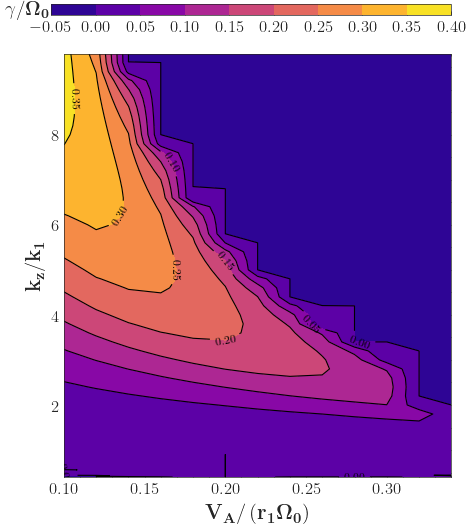

In [10]:
# combined_matrix = np.hstack((np.flip(complex_freqs_MRI_1k1_Kep_ud,1), complex_freqs_MRI_1k1_Kep_uu))

# kn_arr_comb = np.concatenate((np.flip(kn_arr_down), kn_arr))

###################### Growth Rate
fig, ax = plt.subplots(figsize=(5,5.5))
contour = plt.contourf(VA_N_arr_up, kn_arr_comb, np.transpose(combined_matrix.imag), levels=7, cmap = 'plasma')
contours = plt.contour(VA_N_arr_up, kn_arr_comb, np.transpose(combined_matrix.imag), levels=7, colors='black', linewidths=0.8)
plt.clabel(contours, inline=True, fontsize=8)
ax.set_xlabel(r'$\mathbf{V_A/\left(r_1\Omega_0\right)}$', fontsize = 15)
ax.set_ylabel(r'$\mathbf{k_z/k_1}$', fontsize = 15)
# Add a small colorbar at the top right
# cax = fig.add_axes([0.3, .92, 0.6, 0.02])   # [left, bottom, width, height]
cax = fig.add_axes([0.1, .95, 0.8, 0.02])
cbar = fig.colorbar(contour, cax=cax, orientation="horizontal")
cbar.ax.set_ylabel(r'$\mathbf{\gamma/\Omega_0}$', labelpad=17.5, rotation=0, va='center', fontsize = 14)

# ax.set_xlim(0.1,0.3)
plt.savefig(f'Scaling/kz-VA-MRI.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(f'Scaling/kz-VA-MRI.pdf', dpi = 400, bbox_inches = 'tight')

plt.savefig(f'Scaling/kz-VA-MRI.svg', dpi = 400, bbox_inches = 'tight', format = 'svg')
plt.show()


array([80.        , 78.04878049, 76.19047619, 74.41860465, 72.72727273,
       71.11111111, 69.56521739, 68.08510638, 66.66666667, 65.30612245,
       64.        , 62.74509804, 61.53846154, 60.37735849, 59.25925926,
       58.18181818, 57.14285714, 56.14035088, 55.17241379, 54.23728814,
       53.33333333, 52.45901639, 51.61290323, 50.79365079, 50.        ,
       49.23076923, 48.48484848, 47.76119403, 47.05882353, 46.37681159,
       45.71428571, 45.07042254, 44.44444444, 43.83561644, 43.24324324,
       42.66666667, 42.10526316, 41.55844156, 41.02564103, 40.50632911,
       40.        , 39.50617284, 39.02439024, 38.55421687, 38.0952381 ,
       37.64705882, 37.20930233, 36.7816092 , 36.36363636, 35.95505618,
       35.55555556, 35.16483516, 34.7826087 , 34.40860215, 34.04255319,
       33.68421053, 33.33333333, 32.98969072, 32.65306122, 32.32323232,
       32.        , 32.        , 26.66666667, 22.85714286, 20.        ,
       17.77777778, 16.        , 14.54545455, 13.33333333, 12.30

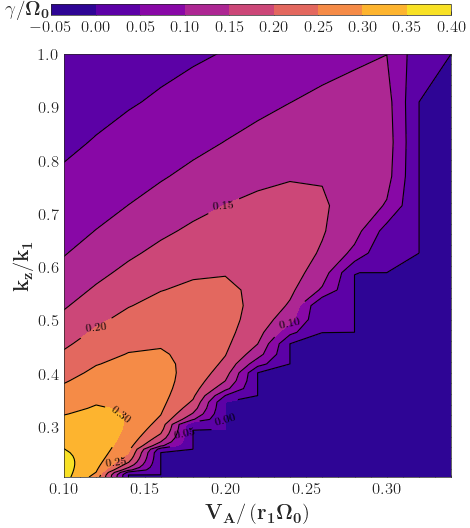

In [ ]:
# combined_matrix = np.hstack((np.flip(complex_freqs_MRI_1k1_Kep_ud,1), complex_freqs_MRI_1k1_Kep_uu))

# kn_arr_comb = np.concatenate((np.flip(kn_arr_down), kn_arr))
y_arr = 2*np.pi/(r2-1)/(kn_arr_comb*np.pi/4)
###################### Growth Rate
fig, ax = plt.subplots(figsize=(5,5.5))
contour = plt.contourf(VA_N_arr_up, y_arr, np.transpose(combined_matrix.imag), levels=7, cmap = 'plasma')
contours = plt.contour(VA_N_arr_up, y_arr, np.transpose(combined_matrix.imag), levels=7, colors='black', linewidths=0.8)
plt.clabel(contours, inline=True, fontsize=8)
ax.set_xlabel(r'$\mathbf{V_A/\left(r_1\Omega_0\right)}$', fontsize = 15)
ax.set_ylabel(r'$\mathbf{\Delta z / \Delta r}$', fontsize = 15)
# Add a small colorbar at the top right
# cax = fig.add_axes([0.3, .92, 0.6, 0.02])   # [left, bottom, width, height]
cax = fig.add_axes([0.1, .95, 0.8, 0.02])
cbar = fig.colorbar(contour, cax=cax, orientation="horizontal")
cbar.ax.set_ylabel(r'$\mathbf{\gamma/\Omega_0}$', labelpad=17.5, rotation=0, va='center', fontsize = 14)

# ax.set_xlim(0.1,0.3)
ax.set_ylim(np.min(y_arr),1)
plt.savefig(f'Scaling/kz-VA-MRI-Rat.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(f'Scaling/kz-VA-MRI-Rat.pdf', dpi = 400, bbox_inches = 'tight')
plt.savefig(f'Scaling/kz-VA-MRI-Rat.svg', dpi = 400, bbox_inches = 'tight', format = 'svg')
plt.show()

Dump

In [ ]:
# str1 = f'Scaling/kz-VA-Scaling-gr-MRI.pkl'
# str2 = f'Scaling/kz-VA-Scaling-gr-VA-MRI.pkl'
# str3 = f'Scaling/kz-VA-Scaling-gr-kn-MRI.pkl'

# with open(str1, 'wb') as f:
#     pickle.dump(combined_matrix, f)

# with open(str2, 'wb') as f:
#     pickle.dump(VA_N_arr_up, f)
    
# with open(str3, 'wb') as f:
#     pickle.dump(kn_arr_comb, f)

In [7]:
str1 = f'Scaling/kz-VA-Scaling-gr-MRI.pkl'
str2 = f'Scaling/kz-VA-Scaling-gr-VA-MRI.pkl'
str3 = f'Scaling/kz-VA-Scaling-gr-kn-MRI.pkl'

with open(str1, 'rb') as f:
    combined_matrix = pickle.load(f)

with open(str2, 'rb') as f:
    VA_N_arr_up = pickle.load(f)

with open(str3, 'rb') as f:
    kn_arr_comb = pickle.load(f)